# Sentiment analysis of movie (IMDB) reviews 

using dataset provided by the ACL 2011 paper, see http://ai.stanford.edu/~amaas/data/sentiment/.

Dataset can be downloaded separately from http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz, but wont be necessary as the download process has been embedded in the notebook and source file.

### Table of Contents<a class="anchor" id="table"></a>
* [Data exploration](#data_e)
* [Modelling](#model)
    * [Logistic Regression](#logis)
        * [Logistic Regression with bag of word](#logis_bag)
        * [Logistic Regression with TFIDF](#logis_tfidf)
        * [Logistic Regress model using TfidfVectorizer and different values for C hyperparameter](#logis_tfidf_hyp)
        * [Logistic Regression with bag of word with Scikit-learn](#logis_bag_scikit)
    * [Random Forest](#randfor)
        * [Random Forest with bag of word](#rand_for_bag)
        * [Random Forest with TFIDF](#rand_for_tfidf)
    * [Display scores for all trained models](#disp_sco)


In [1]:
# uncomment these for Google collab, will have already been installed in local environment 
# if 'pip install -r requirements.txt' has been run
#!pip install nltk
#!pip install --upgrade gensim

import numpy as np
import os
import os.path

from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
import nltk


import glob
from gensim.models import Word2Vec

import time

[nltk_data] Downloading package punkt to /home/jeremie/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
import wget
import tarfile

# By checking if the directory exists first, we allow people to delete the tarfile without the notebook re-downloading it
if os.path.isdir('aclImdb'):
    print("Dataset directory exists, taking no action")
else:    
    if not os.path.isfile('aclImdb_v1.tar.gz'):
        print("Downloading dataset")
        #!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
        wget.download('http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz')
    else:
        print("Dataset already downloaded")
    
    print("Unpacking dataset")
    #!tar -xf aclImdb_v1.tar.gz 
    tar = tarfile.open("aclImdb_v1.tar.gz")
    tar.extractall()
    tar.close()
    print("Dataset unpacked in aclImdb")


Dataset directory exists, taking no action


In [3]:
# notebook configuration
SAMPLE_SIZE=1000

In [4]:
time_beginning_of_notebook = time.time()

positive_sample_file_list = glob.glob(os.path.join('aclImdb/train/pos', "*.txt"))
positive_sample_file_list = positive_sample_file_list[:SAMPLE_SIZE]

negative_sample_file_list = glob.glob(os.path.join('aclImdb/train/neg', "*.txt"))
negative_sample_file_list = negative_sample_file_list[:SAMPLE_SIZE]

import re

# load doc into memory
# regex to clean markup elements 
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r', encoding='utf8')
    # read all text
    text = re.sub('<[^>]*>', ' ', file.read())
    #text = file.read()
    # close the file
    file.close()
    return text


<a href='#table'>Back</a>
# Data exploration<a class="anchor" id="data_e"></a>

In [5]:
positive_strings = [load_doc(x) for x in positive_sample_file_list]
#print('\n Positive reviews \n ',positive_strings[:5])

negative_strings = [load_doc(x) for x in negative_sample_file_list]
#print('\n Negative reviews \n ', negative_strings[:5])
    

In [6]:
positive_tokenized = [word_tokenize(s) for s in positive_strings]
#print('\n Positive tokenized 1 \n {} \n\n Positive tokenized 2 \n {}'. format(positive_tokenized[1], positive_tokenized[2]))


In [7]:
negative_tokenized = [word_tokenize(s) for s in negative_strings]
#print('\n Negative tokenized 1 \n {} \n\n  Negative tokenized 2 \n {}'. format(negative_tokenized[1], negative_tokenized[2]))

In [8]:
# load doc into memory
with open('aclImdb/imdb.vocab', encoding='utf8') as f:
    #content = f.readlines()
    universe_vocabulary = [x.strip() for x in f.readlines()]

print("Word count across all reviews (before stripping tokens):", sum([len(token) for token in positive_tokenized]))

#Checking the not alphanumeric characters in vocabulary
non_alphanumeric_set = set()
for word in universe_vocabulary:
    non_alphanumeric_set |= set(re.findall('\W', word))
print('Non alphanumeric characters found in universe vocabulary', non_alphanumeric_set)


stripped_positive_tokenized = []
for tokens in positive_tokenized:
  stripped_positive_tokenized.append([token.lower() for token in tokens if token.lower() in universe_vocabulary])

print("Word count across all reviews (after stripping tokens):", sum([len(token) for token in stripped_positive_tokenized]))

Word count across all reviews (before stripping tokens): 269930
Non alphanumeric characters found in universe vocabulary {';', '-', '?', ')', '[', '(', '=', ']', ':', '}', '!', "'"}
Word count across all reviews (after stripping tokens): 233435


In [9]:
print("Word count across all reviews (before stripping tokens):", sum([len(token) for token in positive_tokenized]))
stripped_negative_tokenized = []
for tokens in negative_tokenized:
  stripped_negative_tokenized.append([token.lower() for token in tokens if token.lower() in universe_vocabulary])

print("Word count across all reviews (after stripping tokens):", sum([len(token) for token in stripped_negative_tokenized]))

Word count across all reviews (before stripping tokens): 269930
Word count across all reviews (after stripping tokens): 227105


<a href='#table'>Back</a>
# Modelling <a class="anchor" id="model"></a> 

We have decided to do the use the below models and vectorisation techniques to test our their accuracy / score, the idea is to use a one model and one vectorization technique and plot a score.

**Vectorisation techniques**
- Bag of Words
- TFIDF (weighted bag of words) http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
- mapping words to plain integers
- mapping words to embedding vectors


**Simple models**

- Logistic Regression
- Random Forst
- LSTM
- GRU
- CNN

**Embeddings to try**
- Word2Vec
- FastText
- Glove

**APIs we used**
- Introducing Pipeline: http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
- Introducing cross_val_score http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html

In [10]:
scores=[["title","train_acc","test_acc"]]

## Logistic Regression <a class="anchor" id="logis"></a> 


### Logistic Regress model using Bag of Words vectorisation technique<a class="anchor" id="logis_bag"></a> 

In [11]:
import pandas as pd
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

df_positives = pd.DataFrame({'reviews':[load_doc(x) for x in positive_sample_file_list], 'sentiment': np.ones(SAMPLE_SIZE)})
df_negatives = pd.DataFrame({'reviews':[load_doc(x) for x in negative_sample_file_list], 'sentiment': np.zeros(SAMPLE_SIZE)})

print("Positive review: {} \n".format(df_positives['reviews'][1][0:200]))
print("Negative review: {}".format(df_negatives['reviews'][1][0:200]))

df = pd.concat([df_positives, df_negatives], ignore_index=True)

df = shuffle(df)

X_train, X_test, y_train, y_test = train_test_split(df['reviews'], df['sentiment'], test_size=0.25)




Positive review: NYC model Alison Parker (Cristina Raines) rents a room in an old brownstone where she meets a few bizarre neighbors and experiences some creepy hallucinations. As lawyer boyfriend Michael Lerman (Chri 

Negative review: The reason the DVD releases of this film are in black and white is because nobody can get their hands on a color print of this public domain film, a modest sea story at best.  Distributed for televisi


In [12]:
CountVec = CountVectorizer()
lr_CV = Pipeline([('vect', CountVec), ('clf', LogisticRegression(random_state=0))])
lr_CV.fit(X_train, y_train)
train_acc=lr_CV.score(X_train, y_train)
print('Train accuracy {}'.format(train_acc))
test_acc=lr_CV.score(X_test, y_test)
print('Test accuracy {}'.format(test_acc))

# # Trying with cross_val_score
lr = LogisticRegression()
k_folds = 10
X_train_CV = CountVec.fit_transform(X_train)
type(X_train_CV)
print('Train accuracy list {} '.format(cross_val_score(lr, X_train_CV, y_train, cv= k_folds))) 
print('Train accuracy mean {} '.format(cross_val_score(lr, X_train_CV, y_train, cv= k_folds).mean()))

scores.append(["Logistic Reg with BoW",train_acc,test_acc])

Train accuracy 1.0
Test accuracy 0.806
Train accuracy list [0.8013245  0.83333333 0.80666667 0.86666667 0.82666667 0.81333333
 0.81333333 0.84       0.82666667 0.8590604 ] 
Train accuracy mean 0.8287051572662489 


### Logistic Regress model using TfidfVectorizer vectorisation technique<a class="anchor" id="logis_tfidf"></a> 

In [13]:
tfidf = TfidfVectorizer(strip_accents=None, lowercase=False, preprocessor=None)

lr_tfidf = Pipeline([('vect', tfidf), ('clf', LogisticRegression(random_state=0))])
lr_tfidf.fit(X_train, y_train)
train_acc=lr_tfidf.score(X_train, y_train)
print('Train accuracy {}'.format(train_acc))
test_acc=lr_tfidf.score(X_test, y_test)
print('Test accuracy {}'.format(test_acc))

# Trying with cross_val_score
lr = LogisticRegression()
k_folds = 10
X_train_tfidf = tfidf.fit_transform(X_train)
print('Train accuracy list {} '.format(cross_val_score(lr, X_train_tfidf, y_train, cv= k_folds))) 
print('Train accuracy mean {} '.format(cross_val_score(lr, X_train_tfidf, y_train, cv= k_folds).mean()))

scores.append(["Logistic Reg with Tfidf",train_acc,test_acc])

Train accuracy 0.966
Test accuracy 0.816
Train accuracy list [0.8013245  0.85333333 0.79333333 0.84666667 0.76666667 0.80666667
 0.81333333 0.87333333 0.82666667 0.86577181] 
Train accuracy mean 0.8247096315391795 


### Logistic Regress model using TfidfVectorizer and different values for C hyperparameter<a class="anchor" id="logis_tfidf_hyp"></a> 

In [14]:
C_values = np.arange(1,2,0.1)
results = []

for value in C_values:   
    lr_tfidf = Pipeline([('vect', tfidf), ('clf', LogisticRegression(random_state=0, C=value))])
    lr_tfidf.fit(X_train, y_train)
    train_score = lr_tfidf.score(X_train, y_train)
    score = lr_tfidf.score(X_test, y_test)
    print('C_value {} Test Score {} Train_score {}'.format(value, score, train_score))
    results.append(score)

time_end_of_notebook = time.time()

C_value 1.0 Test Score 0.816 Train_score 0.966
C_value 1.1 Test Score 0.818 Train_score 0.9693333333333334
C_value 1.2000000000000002 Test Score 0.818 Train_score 0.972
C_value 1.3000000000000003 Test Score 0.818 Train_score 0.974
C_value 1.4000000000000004 Test Score 0.818 Train_score 0.9766666666666667
C_value 1.5000000000000004 Test Score 0.82 Train_score 0.9793333333333333
C_value 1.6000000000000005 Test Score 0.82 Train_score 0.9813333333333333
C_value 1.7000000000000006 Test Score 0.822 Train_score 0.982
C_value 1.8000000000000007 Test Score 0.822 Train_score 0.9853333333333333
C_value 1.9000000000000008 Test Score 0.824 Train_score 0.986


In [15]:
table_models_vectorization = pd.DataFrame(
     {'Models':                   ["Logistic Regression", "Logistic Regression", "Logistic Regression"], 
      'Vectorisation techniques': ["Bag of Words",        "Word2Vec", "TFIDF"], 
      'Score':                    [score,                 "Pending", lr_tfidf.score(X_train, y_train) ]},
    columns=['Models','Vectorisation techniques','Score']
)
print("Sample size:", SAMPLE_SIZE)

duration = time_end_of_notebook - time_beginning_of_notebook

print("Full notebook execution duration:", duration, "seconds")
print("Full notebook execution duration:", duration / 60, "minutes")

table_models_vectorization

Sample size: 1000
Full notebook execution duration: 110.8671441078186 seconds
Full notebook execution duration: 1.84778573513031 minutes


,Models,Vectorisation techniques,Score
0,Logistic Regression,Bag of Words,0.824
1,Logistic Regression,Word2Vec,Pending
2,Logistic Regression,TFIDF,0.986


### Logistic Regress model using Bag of Words with scikit-learn<a class="anchor" id="logis_bag_scikit"></a> 

**The below two code blocks replaces the original/inital BoW implementation using Scikit-learn**

In [16]:
CountVec = CountVectorizer()
# Creating the BoW with the set of all the documents and transforming the documents in feature vectors
bag_of_words = CountVec.fit_transform(df['reviews'])

print(type(bag_of_words))
print('\n Number of raws {} (documents) -- Number of columns {} (vocabulary) \n'.format(bag_of_words.shape[0], bag_of_words.shape[1]))

# https://machinelearningmastery.com/sparse-matrices-for-machine-learning/
# This is a sparse matrix 
print('\n Type of bag_of_words {} \n'.format(type(bag_of_words)))
sparsity = 1.0 - bag_of_words.nnz / (bag_of_words.shape[0] * bag_of_words.shape[1])
print('\n Sparsity {} \n'.format(sparsity))

# This is a  
print('\n Type of bag_of_words.toarray {} \n'.format(type(bag_of_words.toarray())))

# In CountVec we have the vocabulary as an attribute
print('\n Type of CountVec.vocabulary {} \n'.format(type(CountVec.vocabulary_)))
print('A sample of CountVec.vocabulary_ {}'.format([(k, v) for k, v in CountVec.vocabulary_.items() if v < 1000][0:5]))

# In bag_of_words we have the vector features representing each single document 
print('\n Type of bag_of_words.toarray() {} \n')
print('\n First feature vector, representing the first document \n', bag_of_words[0, :2])

<class 'scipy.sparse.csr.csr_matrix'>

 Number of raws 2000 (documents) -- Number of columns 25190 (vocabulary) 


 Type of bag_of_words <class 'scipy.sparse.csr.csr_matrix'> 


 Sparsity 0.9945679436284239 


 Type of bag_of_words.toarray <class 'numpy.ndarray'> 


 Type of CountVec.vocabulary <class 'dict'> 

A sample of CountVec.vocabulary_ [('all', 914), ('actors', 543), ('actor', 542), ('acting', 528), ('also', 971)]

 Type of bag_of_words.toarray() {} 


 First feature vector, representing the first document 
 


In [17]:
# Lets get our training and test data
X_train, X_test, y_train, y_test = train_test_split(bag_of_words.toarray(), df['sentiment'].values, test_size=0.25)


In [18]:
clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)
print('Using score function: {}'.format(clf.score(X_test, y_test)))


results = [(predicted, actual) for predicted, actual in zip(clf.predict(X_test),  y_test) 
           if  predicted == actual]

print('Percentage of correct predicted values: {}'.format(len(results)/len(y_test)))

Using score function: 0.852
Percentage of correct predicted values: 0.852


## RandomForestClassifer<a class="anchor" id="rand_for"></a> 

### RandomForestClassifer with bag of words<a class="anchor" id="rand_for_bag"></a>

In [19]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train, y_train)
train_acc=clf.score(X_train, y_train)
test_acc=clf.score(X_test, y_test)
print('Using score function: {}'.format(test_acc))


results = [(predicted, actual) for predicted, actual in zip(clf.predict(X_test),  y_test) 
           if  predicted == actual]

print('Percentage of correct predicted values: {}'.format(len(results)/len(y_test)))

scores.append(["Random Forest with BoW",train_acc,test_acc])

/home/jeremie/.local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Using score function: 0.824
Percentage of correct predicted values: 0.824


### RandomForestClassifer with TFIDF (Pipeline)<a class="anchor" id="rand_for_tfidf"></a>

In [20]:
tfidf = TfidfVectorizer(strip_accents=None, lowercase=False, preprocessor=None)


X_train, X_test, y_train, y_test = train_test_split(df['reviews'], df['sentiment'], test_size=0.25)

lr_tfidf = Pipeline([('vect', tfidf), ('clf', RandomForestClassifier(n_estimators=1000))])
lr_tfidf.fit(X_train, y_train)
train_acc=lr_tfidf.score(X_train, y_train)
print('Train accuracy {}'.format(train_acc))
test_acc=lr_tfidf.score(X_test, y_test)
print('Test accuracy {}'.format(test_acc))

# Trying with cross_val_score
lr = LogisticRegression()
k_folds = 10
X_train_tfidf = tfidf.fit_transform(X_train)
print('Train accuracy list {} '.format(cross_val_score(lr, X_train_tfidf, y_train, cv= k_folds))) 
print('Train accuracy mean {} '.format(cross_val_score(lr, X_train_tfidf, y_train, cv= k_folds).mean()))

scores.append(["Random Forest with Tfidf",train_acc,test_acc])

Train accuracy 1.0
Test accuracy 0.844
Train accuracy list [0.77483444 0.8410596  0.8410596  0.85333333 0.78       0.86666667
 0.83333333 0.80536913 0.81208054 0.84563758] 
Train accuracy mean 0.8253374224039586 


## Display scores for all trained models<a class="anchor" id="disp_sco"></a>

                      title  train_acc  test_acc
0     Logistic Reg with BoW      1.000     0.806
1   Logistic Reg with Tfidf      0.966     0.816
2    Random Forest with BoW      1.000     0.824
3  Random Forest with Tfidf      1.000     0.844


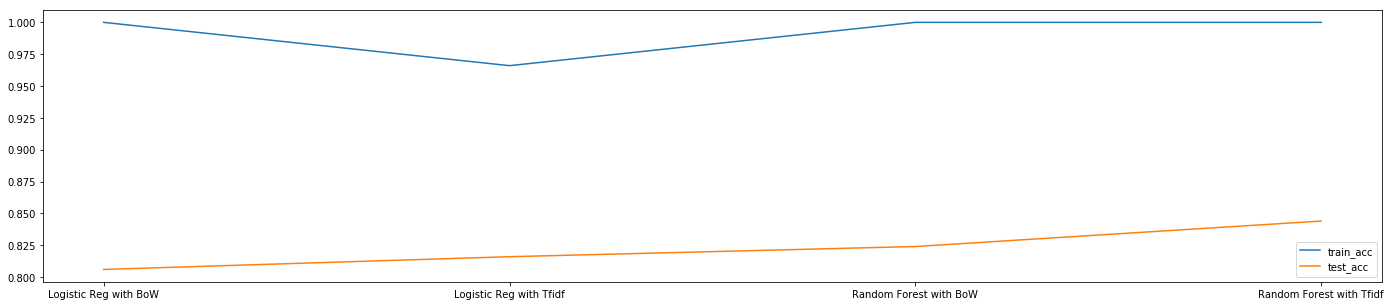

In [22]:
import matplotlib.pyplot as plt

scores_df=pd.DataFrame(data=scores[1:],columns=scores[0])

print(scores_df)
scores_df.train_acc=scores_df.train_acc.astype(float)
scores_df.test_acc=scores_df.test_acc.astype(float)
plt.rcParams["figure.figsize"] = [24,5]

ax=scores_df.plot(y=["train_acc","test_acc"])
ax.set_xticks(scores_df.index);
ax.set_xticklabels(scores_df.title);


Notes Jeremie 22/11: if you run the algorithms multiple times, you might get different values for accuracies, and random forest is not necessarily consistently better.

Might be worth reevaluating all algorithms using k-folds cross validation technique to have hopefully more consistent results